In [1]:
import sys, os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ensure project root on sys.path so `src` imports work when running the notebook
repo_root = Path('..').resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

sns.set(style='whitegrid')
RAW_DIR = Path('../data/raw')
OUT_DIR = Path('../results/figures')
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
# find latest shots CSV
files = sorted(RAW_DIR.glob('shots_events_*.csv'), key=os.path.getmtime)
assert files, 'No shots_events_*.csv found in data/raw/'
path = files[-1]
print('Loading', path)

# detect duplicated header row pattern and read accordingly
def read_and_fix(path):
    head = pd.read_csv(path, header=None, nrows=2)
    first = head.iloc[0].fillna('').astype(str)
    second = head.iloc[1].fillna('').astype(str)
    nonempty_first = (first.str.strip()!='').sum()
    nonempty_second = (second.str.strip()!='').sum()
    if nonempty_first<=2 and nonempty_second>nonempty_first:
        return pd.read_csv(path, header=1)
    return pd.read_csv(path, header=0)

df = read_and_fix(path)
df.columns = [c.strip() if isinstance(c, str) else c for c in df.columns]
df.head()

Loading ..\data\raw\shots_events_20251221T171400Z.csv


,minute,player,team,xG,PSxG,outcome,distance,body_part,notes,SCA 1,SCA 1.1,SCA 2,SCA 2.1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,player,event,player,event
1,3,Hugo Ekitike,Liverpool,0.02,0.04,Saved,26.0,Right Foot,NaN,Cody Gakpo,Pass (Live),Alexis Mac Allister,Pass (Live)
2,4,Mohamed Salah,Liverpool,0.02,0.22,Saved,18.0,Left Foot,NaN,Hugo Ekitike,Pass (Live),Virgil van Dijk,Pass (Live)
3,5,Virgil van Dijk,Liverpool,0.13,0.00,Off Target,10.0,Head,NaN,Mohamed Salah,Pass (Live),Jeremie Frimpong,Pass (Live)
4,6,Antoine Semenyo,Bournemouth,0.24,0.00,Off Target,10.0,Right Foot,NaN,Adrien Truffert,Pass (Live),Marcos Senesi,Pass (Live)


Total shots: 4029
Goals: 457


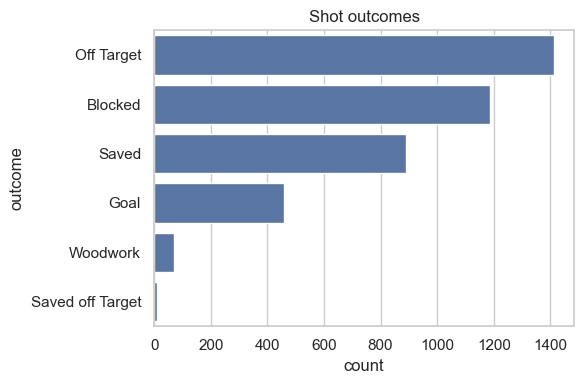

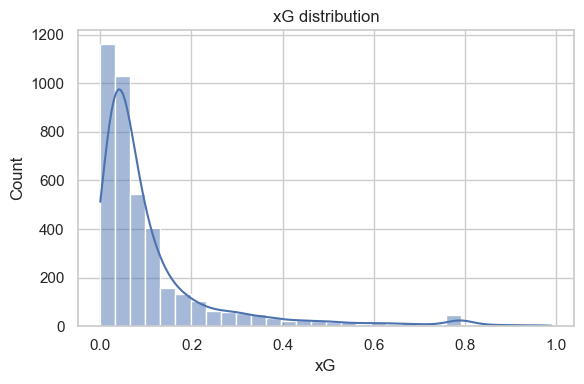

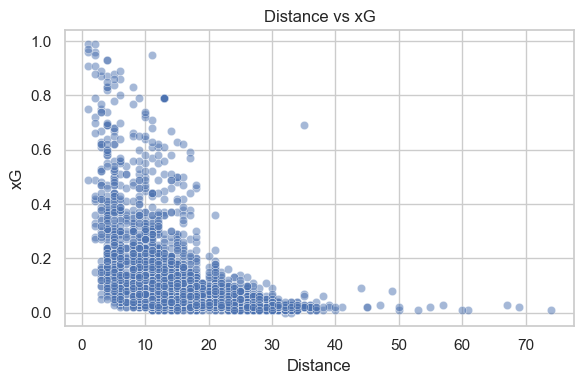

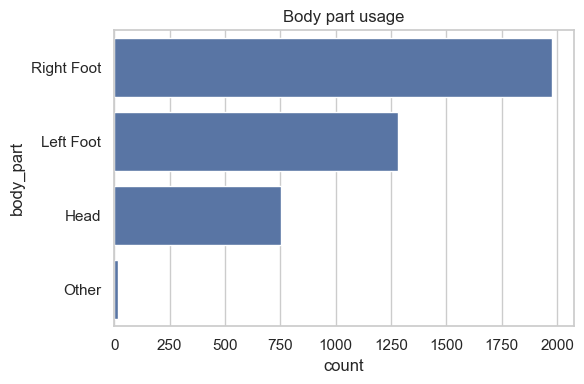

In [3]:
# coercions
for col in ['xG','distance']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print('Total shots:', len(df))
if 'outcome' in df.columns:
    print('Goals:', (df['outcome'].str.lower()=='goal').sum())

# Outcome counts plot
if 'outcome' in df.columns:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.countplot(y=df['outcome'].fillna('Unknown'), order=df['outcome'].value_counts().index, ax=ax)
    ax.set_title('Shot outcomes')
    plt.tight_layout()
    fig.savefig(OUT_DIR / 'notebook_shots_outcome_counts.png')
    plt.show()

# xG histogram
if 'xG' in df.columns:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.histplot(x=df['xG'].dropna().astype(float), bins=30, kde=True, ax=ax)
    ax.set_title('xG distribution')
    plt.tight_layout()
    fig.savefig(OUT_DIR / 'notebook_xg_histogram.png')
    plt.show()

# Distance vs xG
if 'distance' in df.columns and 'xG' in df.columns:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.scatterplot(x=df['distance'].astype(float), y=df['xG'].astype(float), alpha=0.5, ax=ax)
    ax.set_xlabel('Distance')
    ax.set_ylabel('xG')
    ax.set_title('Distance vs xG')
    plt.tight_layout()
    fig.savefig(OUT_DIR / 'notebook_distance_vs_xg.png')
    plt.show()

# Body part counts (column may be 'body_part' or 'body part')
bp_col = None
for c in df.columns:
    if 'body' in str(c).lower():
        bp_col = c
        break
if bp_col is not None:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.countplot(y=df[bp_col].fillna('Unknown'), order=df[bp_col].value_counts().index, ax=ax)
    ax.set_title('Body part usage')
    plt.tight_layout()
    fig.savefig(OUT_DIR / 'notebook_bodypart_counts.png')
    plt.show()